In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [ ]:
data_dir = pathlib.Path("/content/gdrive/Shareddrives/SO-CDX Tribe/hackathon_shelves/data")

In [ ]:
empty = list(data_dir.glob('empty_shelves/*'))
non_empty = list(data_dir.glob('non_empty_shelves/*'))

In [ ]:
batch_size = 8
img_height = 720
img_width = 720

In [ ]:
from keras.applications.vgg16 import preprocess_input

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=456,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 292 files belonging to 2 classes.
Using 205 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 292 files belonging to 2 classes.
Using 87 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['empty_shelves', 'non_empty_shelves']


In [ ]:
for image_batch, labels_batch in train_ds:
  #image_batch = preprocess_input(image_batch)
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 720, 720, 3)
(8,)


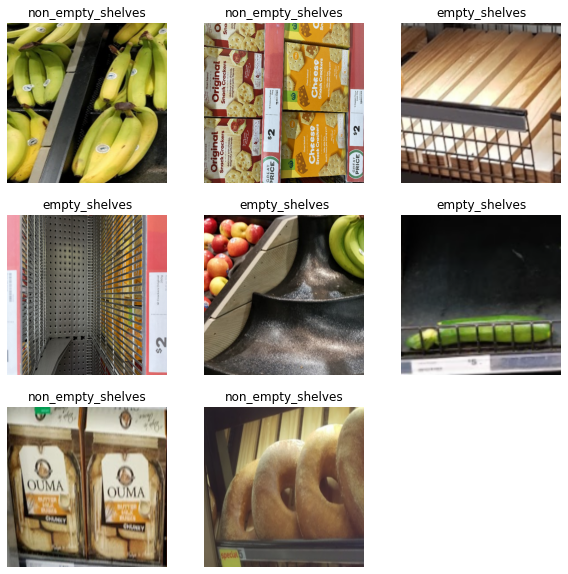

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

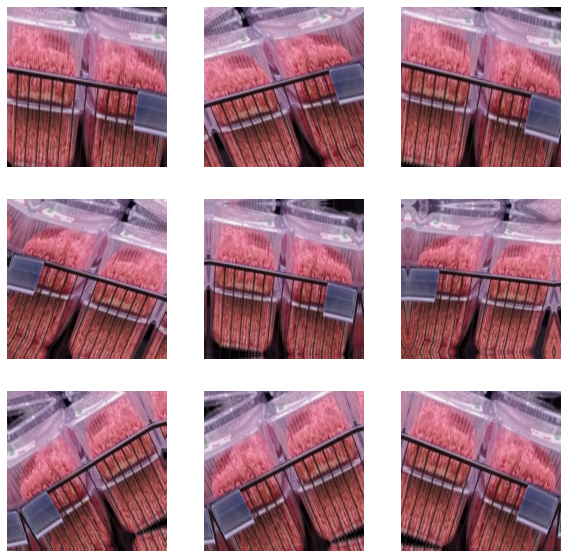

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
base_model = tf.keras.applications.VGG19(input_shape=(720, 720, 3), include_top=False)
base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 22, 22, 512)


In [ ]:
num_classes = 2
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  base_model,
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(2048, activation='relu'),
  layers.Dense(1024, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 720, 720, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 720, 720, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 22, 22, 512)       20024384  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 512)       0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 512)       0         
_________________________________________________________________
flatten (Flatten)            (None, 61952)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)             

In [ ]:
epochs=10
history_original = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
26/26 [==============================] - 1957s 76s/step - loss: 0.8268 - accuracy: 0.5268 - val_loss: 0.6931 - val_accuracy: 0.4483
Epoch 2/10
26/26 [==============================] - 1898s 74s/step - loss: 0.6931 - accuracy: 0.5122 - val_loss: 0.6931 - val_accuracy: 0.4483
Epoch 3/10
26/26 [==============================] - 1899s 74s/step - loss: 0.6931 - accuracy: 0.5122 - val_loss: 0.6931 - val_accuracy: 0.4483
Epoch 4/10
26/26 [==============================] - 1902s 74s/step - loss: 0.6931 - accuracy: 0.5122 - val_loss: 0.6931 - val_accuracy: 0.4483
Epoch 5/10
24/26 [==========================>...] - ETA: 1:44 - loss: 0.6931 - accuracy: 0.5156

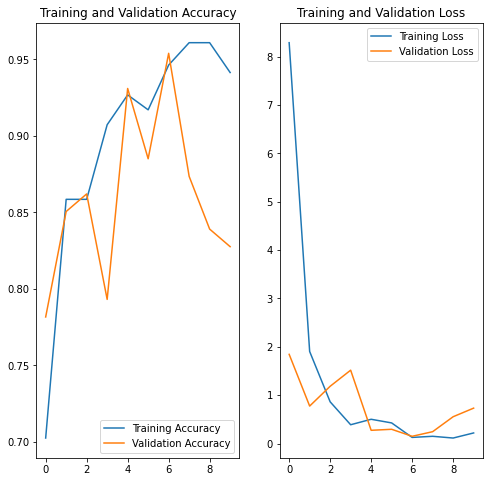

In [ ]:
acc = history_original.history['accuracy']
val_acc = history_original.history['val_accuracy']

loss = history_original.history['loss']
val_loss = history_original.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_data_dir = pathlib.Path("/content/gdrive/Shareddrives/SO-CDX Tribe/hackathon_shelves/test_data")
empty_test = list(test_data_dir.glob('empty_shelves/*'))
non_empty_test = list(test_data_dir.glob('not_empty_shelves/*'))

In [ ]:
print(len(empty_test))
print(len(non_empty_test))

12
12


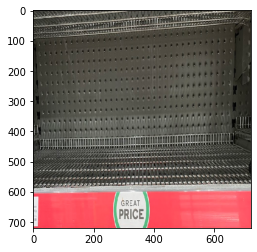

empty_shelves : 97.97 percent


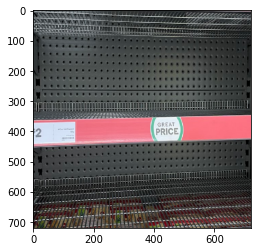

empty_shelves : 99.99 percent


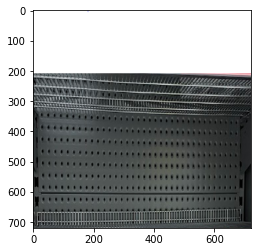

empty_shelves : 99.82 percent


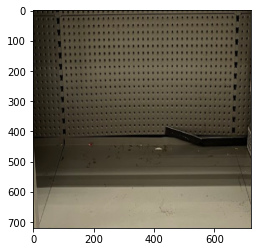

empty_shelves : 99.21 percent


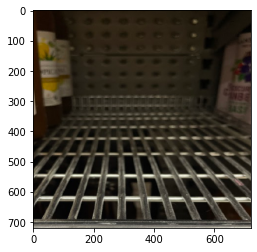

empty_shelves : 99.85 percent


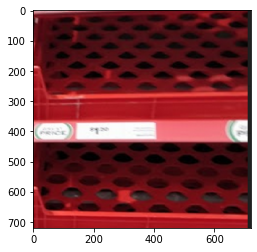

non_empty_shelves : 89.75 percent


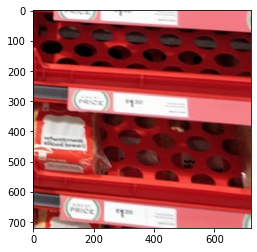

non_empty_shelves : 99.93 percent


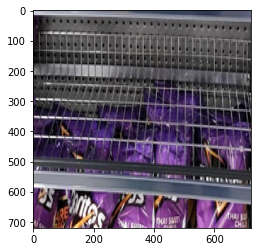

empty_shelves : 77.00 percent


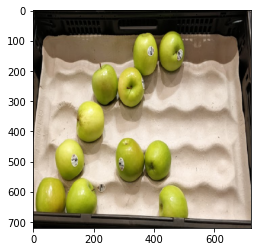

non_empty_shelves : 100.00 percent


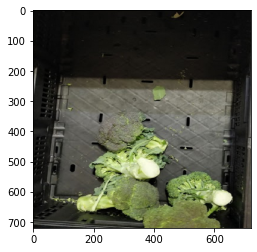

non_empty_shelves : 99.99 percent


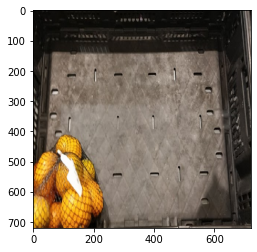

non_empty_shelves : 99.96 percent


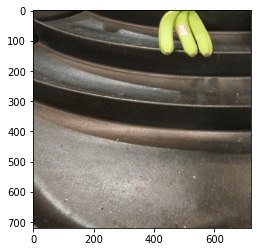

empty_shelves : 89.19 percent


In [ ]:
for test_file in empty_test:
  img = keras.preprocessing.image.load_img(
    test_file, target_size=(img_height, img_width)
  )

  plt.imshow(img)
  plt.show()

  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
    "{} : {:.2f} percent"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

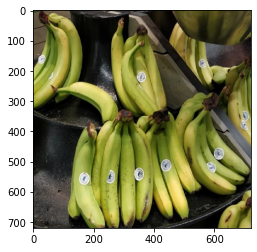

non_empty_shelves : 100.00 percent


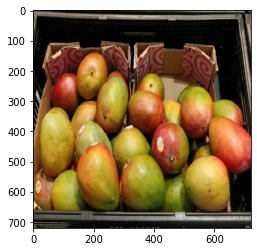

non_empty_shelves : 100.00 percent


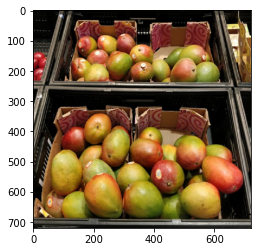

non_empty_shelves : 100.00 percent


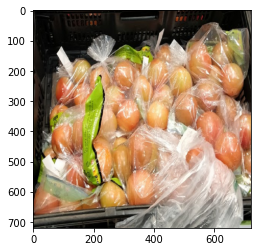

non_empty_shelves : 100.00 percent


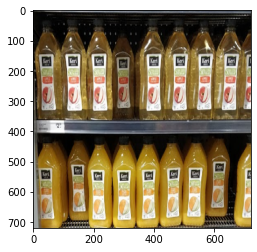

non_empty_shelves : 100.00 percent


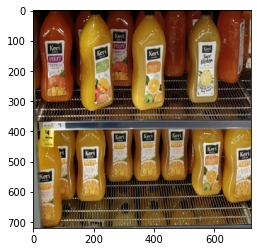

non_empty_shelves : 100.00 percent


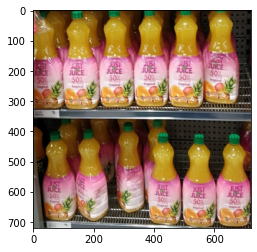

non_empty_shelves : 100.00 percent


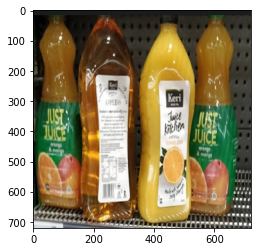

non_empty_shelves : 100.00 percent


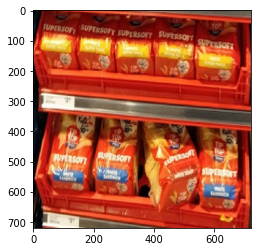

non_empty_shelves : 100.00 percent


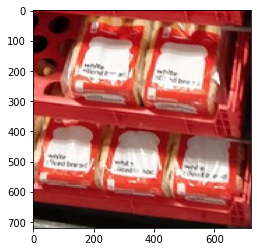

non_empty_shelves : 100.00 percent


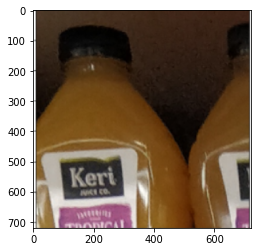

non_empty_shelves : 85.56 percent


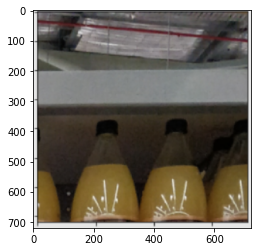

non_empty_shelves : 94.05 percent


In [ ]:
for test_file in non_empty_test:
  img = keras.preprocessing.image.load_img(
    test_file, target_size=(img_height, img_width)
  )
  plt.imshow(img)
  plt.show()
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
    "{} : {:.2f} percent"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

In [ ]:
def sliding_window(image, stepSize, windowSize):
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [ ]:
model

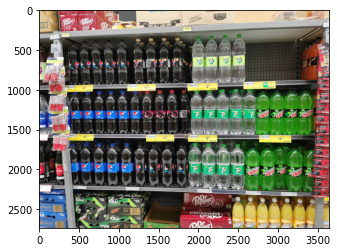

98.46670627593994


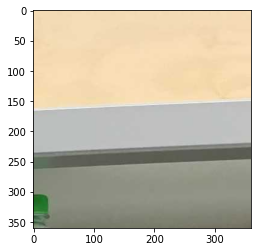

73.28518033027649


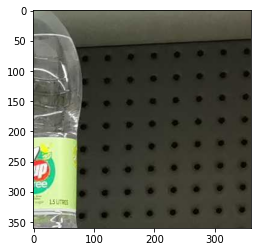

84.94638800621033


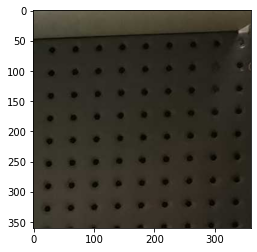

93.129962682724


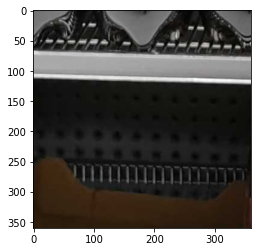

In [ ]:
import cv2
image = cv2.imread("/content/gdrive/Shareddrives/SO-CDX Tribe/hackathon_shelves/entire_shelves/IMG_20210713_131614.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

winW = 360
winH = 360
d = 0

for (x, y, window) in sliding_window(image, stepSize=360, windowSize=(winW, winH)):
  if window.shape[0] != winH or window.shape[1] != winW:
    continue
  clone = image.copy()
  cv2.rectangle(clone, (x, y), (x + winW, y + winH), (255, 0, 0), 10)
  #plt.imshow(clone)
  #plt.show()
  resized = cv2.resize(window, (720, 720), interpolation = cv2.INTER_AREA)
  
  img_array = keras.preprocessing.image.img_to_array(resized)
  img_array = tf.expand_dims(img_array, 0)
  
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  class_predicted = class_names[np.argmax(score)]
  if class_predicted == 'empty_shelves':
    print(100 * np.max(score))
    plt.imshow(window)
    plt.show()
  """if d == 4:
    break
  d =d + 1"""

In [ ]:
model.save("/content/gdrive/Shareddrives/SO-CDX Tribe/hackathon_shelves/assets/model_transfer_one.h5")

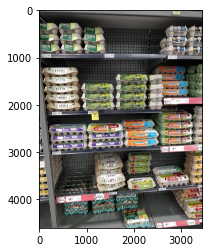

88.16659450531006


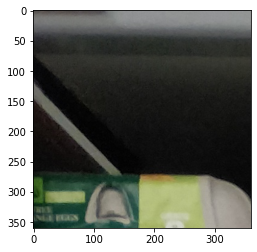

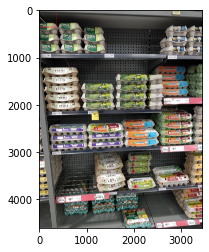

96.11148238182068


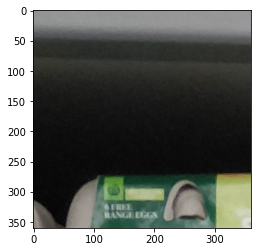

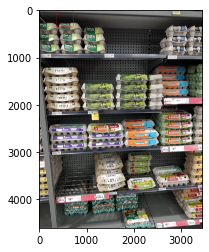

99.71489310264587


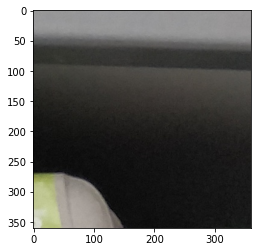

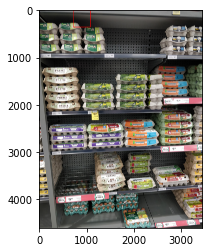

99.71764087677002


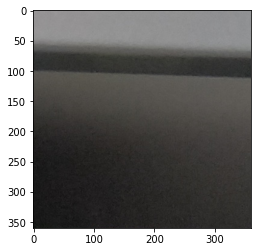

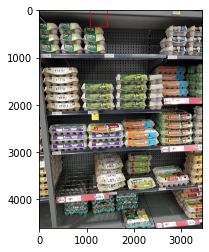

98.64898920059204


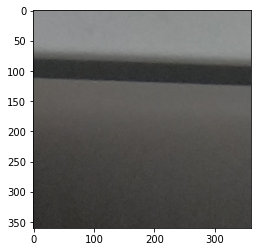

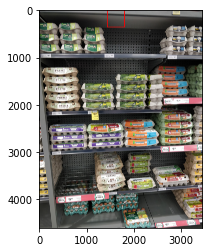

98.41293096542358


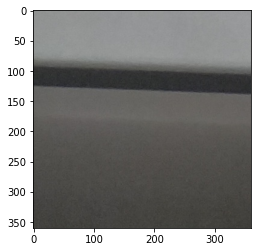

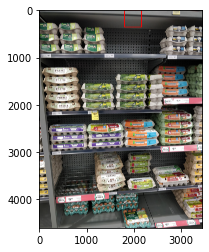

98.88268709182739


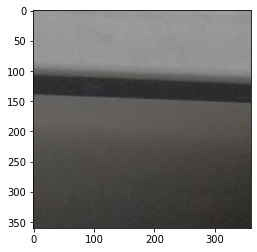

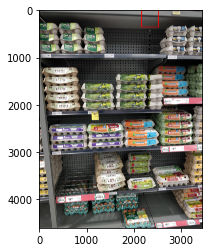

99.69927072525024


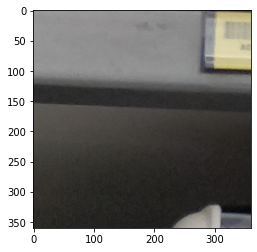

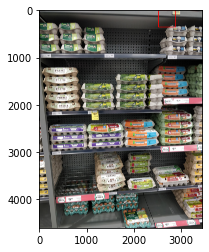

99.22940731048584


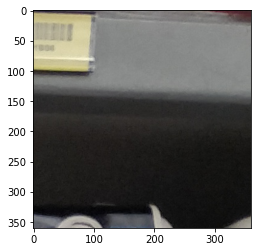

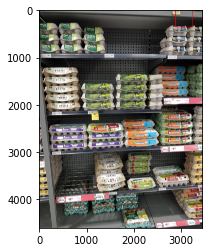

99.7357189655304


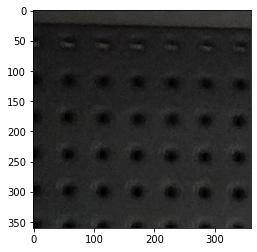

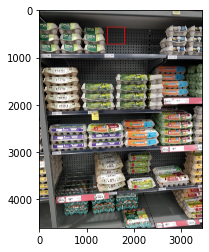

99.69274401664734


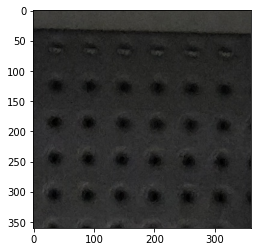

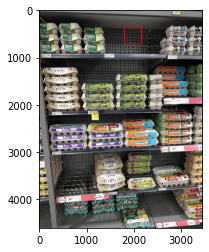

98.08940887451172


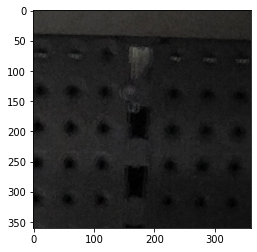

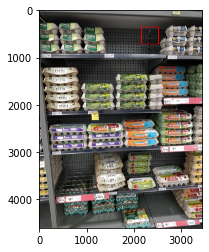

89.31102156639099


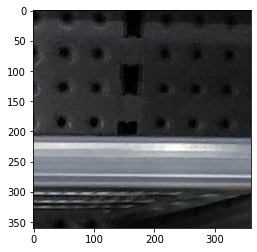

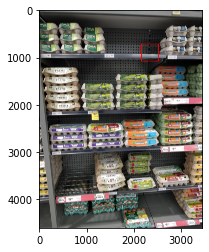

91.6059136390686


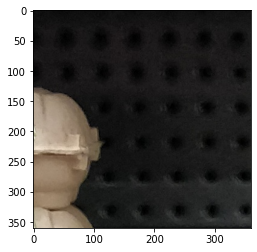

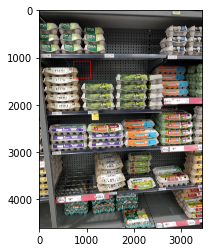

98.51455688476562


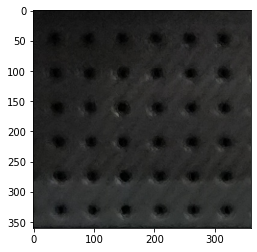

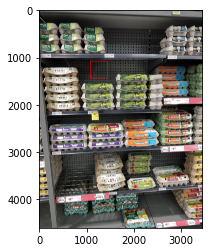

72.08908200263977


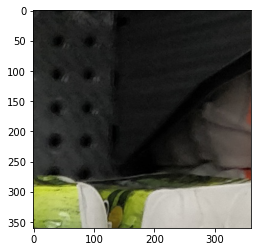

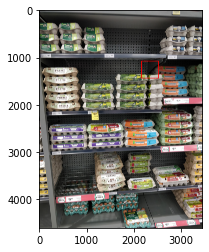

52.85467505455017


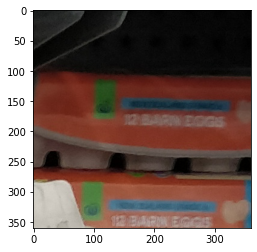

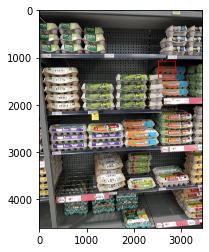

91.82128310203552


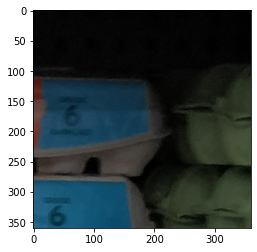

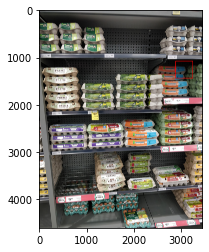

82.97008872032166


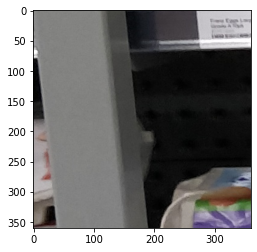

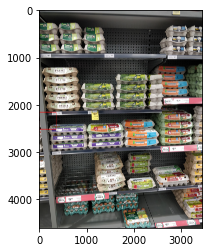

99.55272078514099


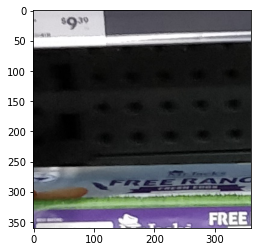

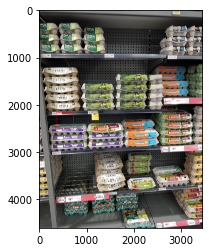

84.80368852615356


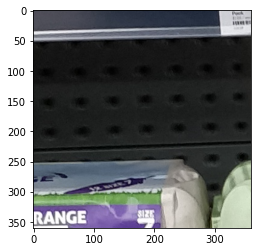

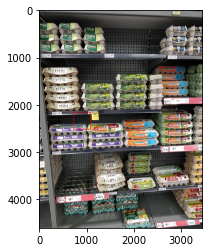

64.47737216949463


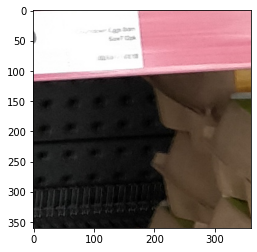

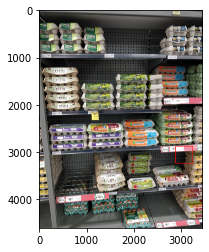

73.39479327201843


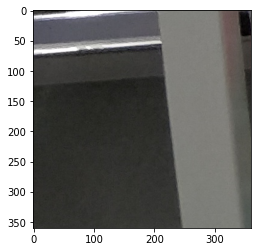

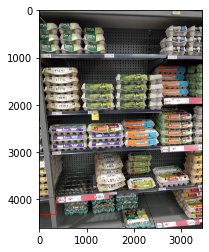

73.4101414680481


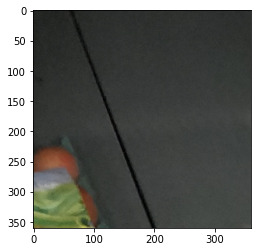

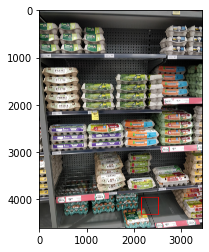

99.74308609962463


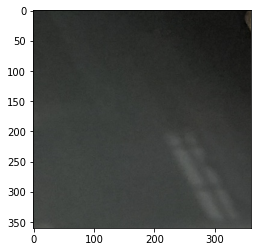

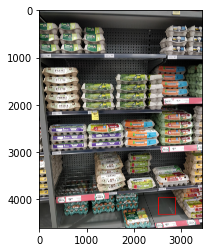

In [ ]:
import cv2
image = cv2.imread("/content/gdrive/Shareddrives/SO-CDX Tribe/hackathon_shelves/entire_shelves/IMG_20210711_174800.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

winW = 360
winH = 360
d = 0

for (x, y, window) in sliding_window(image, stepSize=360, windowSize=(winW, winH)):
  if window.shape[0] != winH or window.shape[1] != winW:
    continue
  clone = image.copy()
  cv2.rectangle(clone, (x, y), (x + winW, y + winH), (255, 0, 0), 10)
  #plt.imshow(clone)
  #plt.show()
  resized = cv2.resize(window, (720, 720), interpolation = cv2.INTER_AREA)
  
  img_array = keras.preprocessing.image.img_to_array(resized)
  img_array = tf.expand_dims(img_array, 0)
  
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  class_predicted = class_names[np.argmax(score)]
  if class_predicted == 'empty_shelves':
    print(100 * np.max(score))
    plt.imshow(window)
    plt.show()
    plt.imshow(clone)
    plt.show()
  
  """if d == 4:
    break
  d =d + 1"""

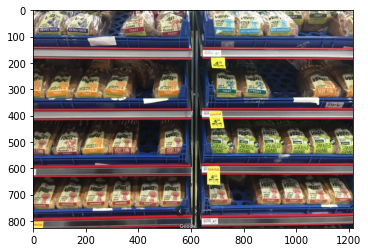

In [ ]:
import cv2
image = cv2.imread("/content/gdrive/Shareddrives/SO-CDX Tribe/hackathon_shelves/entire_shelves/entire_20.PNG")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

winW = 360
winH = 360
d = 0

for (x, y, window) in sliding_window(image, stepSize=360, windowSize=(winW, winH)):
  if window.shape[0] != winH or window.shape[1] != winW:
    continue
  clone = image.copy()
  cv2.rectangle(clone, (x, y), (x + winW, y + winH), (255, 0, 0), 10)
  #plt.imshow(clone)
  #plt.show()
  resized = cv2.resize(window, (720, 720), interpolation = cv2.INTER_AREA)
  
  img_array = keras.preprocessing.image.img_to_array(resized)
  img_array = tf.expand_dims(img_array, 0)
  
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  class_predicted = class_names[np.argmax(score)]
  if class_predicted == 'empty_shelves':
    print(100 * np.max(score))
    plt.imshow(window)
    plt.show()
    plt.imshow(clone)
    plt.show()
  
  """if d == 4:
    break
  d =d + 1"""